In [1]:
from tabpfn.utils import normalize_data, to_ranking_low_mem, remove_outliers
from tabpfn.utils import NOP, normalize_by_used_features_f
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
import torch

def preprocess_input(eval_xs, eval_ys, eval_position, device, preprocess_transform="none",
                     max_features=100, normalize_with_sqrt=False, normalize_with_test=False,
                     normalize_to_ranking=False, categorical_feats=[]):
    import warnings

    if eval_xs.shape[1] > 1:
        raise Exception("Transforms only allow one batch dim - TODO")
    if preprocess_transform != 'none':
        if preprocess_transform == 'power' or preprocess_transform == 'power_all':
            pt = PowerTransformer(standardize=True)
        elif preprocess_transform == 'quantile' or preprocess_transform == 'quantile_all':
            pt = QuantileTransformer(output_distribution='normal')
        elif preprocess_transform == 'robust' or preprocess_transform == 'robust_all':
            pt = RobustScaler(unit_variance=True)

    # eval_xs, eval_ys = normalize_data(eval_xs), normalize_data(eval_ys)
    eval_xs = normalize_data(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position)

    # Removing empty features
    eval_xs = eval_xs[:, 0, :]
    sel = [len(torch.unique(eval_xs[0:eval_ys.shape[0], col])) > 1 for col in range(eval_xs.shape[1])]
    eval_xs = eval_xs[:, sel]
£
    warnings.simplefilter('error')
    if preprocess_transform != 'none':
        eval_xs = eval_xs.cpu().numpy()
        feats = set(range(eval_xs.shape[1])) if 'all' in preprocess_transform else set(
            range(eval_xs.shape[1])) - set(categorical_feats)
        for col in feats:
            try:
                pt.fit(eval_xs[0:eval_position, col:col + 1])
                trans = pt.transform(eval_xs[:, col:col + 1])
                # print(scipy.stats.spearmanr(trans[~np.isnan(eval_xs[:, col:col+1])], eval_xs[:, col:col+1][~np.isnan(eval_xs[:, col:col+1])]))
                eval_xs[:, col:col + 1] = trans
            except:
                pass
        eval_xs = torch.tensor(eval_xs).float()
    warnings.simplefilter('default')

    eval_xs = eval_xs.unsqueeze(1)

    # TODO: Caution there is information leakage when to_ranking is used, we should not use it
    eval_xs = remove_outliers(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position) \
            if not normalize_to_ranking else normalize_data(to_ranking_low_mem(eval_xs))
    # Rescale X
    eval_xs = normalize_by_used_features_f(eval_xs, eval_xs.shape[-1], max_features,
                                            normalize_with_sqrt=normalize_with_sqrt)

    return eval_xs.to(device)

SyntaxError: invalid character '£' (U+00A3) (627831414.py, line 28)

In [ ]:
# import the california dataset
from sklearn.datasets import fetch_california_housing
device = "cuda:0"

california = fetch_california_housing()
X_true = california.data

# normalize X_true with a power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X_true = pt.fit_transform(X_true)
#y = california.target
# create random data with the same shape as the california dataset
import numpy as np
np.random.seed(0)
X_false = np.random.randn(X_true.shape[0], X_true.shape[1])
#X_false = X_true.copy()
X_false = torch.tensor(X_false).float().to(device)
X_false.requires_grad = True

X_true = torch.tensor(X_true).float().to(device)
X_true.requires_grad = False

#merge the two and create a target 0/1 for True False
X = torch.cat((X_true, X_false), dim=0)
y = torch.cat((torch.ones(X_true.shape[0]), torch.zeros(X_false.shape[0])), dim=0).to(device)
# shuffle
perm = torch.randperm(X.shape[0])
X = X[perm]
y = y[perm]

#pad X with zeros to have a shape (-1, 100)
X = torch.cat((X, torch.zeros((X.shape[0], 100 - X.shape[1])).to(device)), dim=1)



In [ ]:
single_eval_pos = 1000
max_samples = 1500
tabpfn_input = X.reshape(X.shape[0], 1, X.shape[1])[:max_samples]
tabpfn_output = transformer_predict(tabpfn, tabpfn_input, y[:max_samples].reshape(-1, 1), eval_position=single_eval_pos, device="cuda:0", no_grad=False, preprocess_transform="none")
tabpfn_output = tabpfn_output.squeeze(0)

In [ ]:
# compute accuracy
y_pred = tabpfn_output.argmax(dim=1)
accuracy = accuracy_score(y[single_eval_pos:max_samples].cpu().numpy(), y_pred.cpu().numpy())
print(f"Accuracy: {accuracy}")

In [ ]:
# compute loss as the entropy of tabpfn_output
loss = torch.mean(torch.sum(-tabpfn_output * torch.log(tabpfn_output + 1e-6), dim=1))
loss.backward()

In [ ]:
0.767 * np.log(0.767) + 0.233 * np.log(0.233)

In [ ]:
tabpfn_output

In [ ]:
torch.sum(-tabpfn_output * torch.log(tabpfn_output + 1e-6), dim=1)

In [ ]:
# import the california dataset
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestClassifier
from tabpfn.utils import normalize_data, to_ranking_low_mem, remove_outliers
import numpy as np
from tabpfn import TabPFNClassifier
rf = RandomForestClassifier()
device = "cuda:0"

#california = fetch_california_housing()
#X_true = california.data

tabpfn = TabPFNClassifier(device="cuda:0").model[2]
# no requires_grad for the tabpfn
for param in tabpfn.parameters():
    param.requires_grad = False

# create a toy dataset, with two features identifcal + noise
X_true = np.random.randn(20_000, 2)
X_true[:, 1] = X_true[:, 0] + 0.1 * np.random.randn(20_000)

n_false_samples = 1000

# normalize X_true with a power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X_true = pt.fit_transform(X_true)
#y = california.target
# create random data with the same shape as the california dataset
import numpy as np
np.random.seed(0)
X_false = np.random.randn(n_false_samples, X_true.shape[1])
#X_false = X_true.copy()
# restrict to the n_false_samples random samples
X_false = X_false[np.random.choice(X_false.shape[0], n_false_samples, replace=False)]
X_false = torch.tensor(X_false).float().to(device)
X_false.requires_grad = True

X_true = torch.tensor(X_true).float().to(device)
X_true.requires_grad = False

optimizer = torch.optim.Adam([X_false], lr=0.1)


n_batches = 100
loss_list = []

cross_entropy = torch.nn.CrossEntropyLoss()

def gaussian_kernel_penalty(X, sigma=1.0, lambda_kernel=0.01):
    n = X.size(0)
    # Compute pairwise differences
    diffs = X.unsqueeze(1) - X.unsqueeze(0)
    # Compute pairwise squared Euclidean distances
    dists_squared = diffs.pow(2).sum(2)
    
    # Compute the Gaussian (RBF) kernel values
    gaussian_kernel_values = torch.exp(-dists_squared / (2 * sigma ** 2))
    
    # Penalize only the points that are very close to each other, ignoring the diagonal (self-comparisons)
    penalty_mask = torch.eye(n, device=X.device) == 0
    close_pairs_penalty = gaussian_kernel_values * penalty_mask
    
    # Apply a scaling factor lambda_kernel to control the strength of the penalty
    penalty = lambda_kernel * close_pairs_penalty.sum()
    
    return penalty

for batch in range(n_batches):
    # select n_false_samples random samples from X_true
    indices = np.random.choice(X_true.shape[0], n_false_samples, replace=False)
    X_true_batch = X_true[indices]
    ##### First version ######
    # shuffle everything
    #merge the two and create a target 0/1 for True False
    X = torch.cat((X_true_batch, X_false), dim=0)
    y = torch.cat((torch.ones(X_true_batch.shape[0]), torch.zeros(X_false.shape[0])), dim=0).to(device).long()
    # shuffle
    perm = torch.randperm(X.shape[0])
    X = X[perm]
    y = y[perm]
    ##### Second version ###### #FIXME
    # true first
    # shuffle X_true_batch
    # perm = torch.randperm(X_true_batch.shape[0])
    # X_true_batch = X_true_batch[perm]
    # # shuffle X_false
    # perm = torch.randperm(X_false.shape[0])
    # X_false = X_false[perm]
    # #merge the two and create a target 0/1 for True False
    # X = torch.cat((X_true_batch, X_false), dim=0)
    # y = torch.cat((torch.ones(X_true_batch.shape[0]), torch.zeros(X_false.shape[0])), dim=0).to(device).long()

    # #pad X with zeros to have a shape (-1, 100)
    # X = torch.cat((X, torch.zeros((X.shape[0], 100 - X.shape[1])).to(device)), dim=1)


    single_eval_pos = n_false_samples
    max_samples = 2 * n_false_samples #TODO remove
    tabpfn_input = X.reshape(X.shape[0], 1, X.shape[1])[:max_samples]
    tabpfn_output = transformer_predict(tabpfn, tabpfn_input, y[:max_samples].reshape(-1, 1), eval_position=single_eval_pos, device="cuda:0", no_grad=False, preprocess_transform="none")
    tabpfn_output = tabpfn_output.squeeze(0)
    #TODO: equalize the probability, because right now the optimization just push the model to always predict 1
    # equalize the mean probability of the two classes and put them between 0 and 1
    # compute the mean for each class
    #mean_proba = torch.mean(tabpfn_output, dim=0)
    # compute the difference between the two means
    #diff = mean_proba[0] - mean_proba[1]
    #print(f"diff: {diff}")
    # add the difference to the two classes
    #tabpfn_output[:, 0] = tabpfn_output[:, 0] + diff
    # compute accuracy
    y_pred = tabpfn_output.argmax(dim=1)
    # rebalance
    print("y_pred", np.unique(y_pred.cpu().numpy(), return_counts=True))
    print("y", np.unique(y[single_eval_pos:max_samples].cpu().numpy(), return_counts=True))
    accuracy = accuracy_score(y[single_eval_pos:max_samples].cpu().numpy(), y_pred.cpu().numpy())
    print(f"Accuracy tabpfn: {accuracy}")
    # compute accuracy of a random forest
    rf.fit(X.cpu().detach().numpy()[:single_eval_pos], y.cpu().numpy()[:single_eval_pos])
    y_pred_rf = rf.predict(X.cpu().detach().numpy()[single_eval_pos:max_samples])
    accuracy_rf = accuracy_score(y.cpu().numpy()[single_eval_pos:max_samples], y_pred_rf)
    print(f"Accuracy RF: {accuracy_rf}")
    ## compute loss as the entropy of tabpfn_output (minus to maximize entropy)
    # TODO: maybe restrict the loss to X_false in test, or at least look at the loss on X_true
    loss = - torch.mean(torch.sum(-tabpfn_output * torch.log2(tabpfn_output + 1e-6), dim=1))
    # compute loss as minus cross entropy
    #loss = - cross_entropy(tabpfn_output, y[single_eval_pos:max_samples])
    # add a penalty on each features to respect the gaussian distribution
    #loss -= 0.05 * torch.mean(torch.sum(torch.exp(-X_false**2), dim=1))
    # add a penalty to prevent each point of X_false to be the same
    #loss -= 0.05 * torch.mean(torch.sum((X_false[1:] - X_false[:-1])**2, dim=1))
    #loss += gaussian_kernel_penalty(X_false, lambda_kernel=0.05, sigma=0.05)
    loss_list.append(loss.item())
    print(f"Loss: {loss.item()}")
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


NameError: name 'normalize_by_used_features_f' is not defined

In [ ]:
# import the california dataset
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestClassifier
from tabpfn.utils import normalize_data, to_ranking_low_mem, remove_outliers
from tabpfn.utils import NOP, normalize_by_used_features_f
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from tabpfn import TabPFNClassifier
import matplotlib.pyplot as plt
rf = RandomForestClassifier()
device = "cuda:0"

california = fetch_california_housing()
X_true = california.data

tabpfn = TabPFNClassifier(device="cuda:0").model[2]
# no requires_grad for the tabpfn
for param in tabpfn.parameters():
    param.requires_grad = False

# create a toy dataset, with two features identifcal + noise
X_true = np.random.randn(20_000, 2)
X_true[:, 1] = X_true[:, 0] + 0.1 * np.random.randn(20_000)

n_false_samples = 1000

# normalize X_true with a power transform
from sklearn.preprocessing import QuantileTransformer
#pt = PowerTransformer()
pt = QuantileTransformer(output_distribution='normal')
X_true = pt.fit_transform(X_true)
#y = california.target
# create random data with the same shape as the california dataset
import numpy as np
np.random.seed(0)
X_false = np.random.randn(n_false_samples, X_true.shape[1])
#X_false = X_true.copy()
# restrict to the n_false_samples random samples
X_false = X_false[np.random.choice(X_false.shape[0], n_false_samples, replace=False)]
X_false = torch.tensor(X_false).float().to(device)
#X_false.requires_grad = True
X_false_train = X_false[:n_false_samples // 2]
X_false_test = X_false[n_false_samples // 2:]
X_false_train.requires_grad = True
X_false_test.requires_grad = True

X_true = torch.tensor(X_true).float().to(device)
X_true.requires_grad = False

optimizer = torch.optim.Adam([X_false_test, X_false_train], lr=0.3)


n_batches = 200
loss_list = []

use_transformer_predict = False
shuffle_false_train_test = True

cross_entropy = torch.nn.CrossEntropyLoss()

def gaussian_kernel_penalty(X, sigma=1.0, lambda_kernel=0.01):
    n = X.size(0)
    # Compute pairwise differences
    diffs = X.unsqueeze(1) - X.unsqueeze(0)
    # Compute pairwise squared Euclidean distances
    dists_squared = diffs.pow(2).sum(2)
    
    # Compute the Gaussian (RBF) kernel values
    gaussian_kernel_values = torch.exp(-dists_squared / (2 * sigma ** 2))
    
    # Penalize only the points that are very close to each other, ignoring the diagonal (self-comparisons)
    penalty_mask = torch.eye(n, device=X.device) == 0
    close_pairs_penalty = gaussian_kernel_values * penalty_mask
    
    # Apply a scaling factor lambda_kernel to control the strength of the penalty
    penalty = lambda_kernel * close_pairs_penalty.sum()
    
    return penalty

for batch in range(n_batches):
    # select n_false_samples random samples from X_true
    indices = np.random.choice(X_true.shape[0], n_false_samples, replace=False)
    X_true_batch = X_true[indices]
    X_true_batch_train = X_true_batch[:n_false_samples // 2]
    X_true_batch_test = X_true_batch[n_false_samples // 2:]
    ##### First version ######
    # shuffle everything
    #merge the two and create a target 0/1 for True False
    X_train = torch.cat((X_true_batch_train, X_false_train), dim=0)
    y_train = torch.cat((torch.ones(X_true_batch_train.shape[0]), torch.zeros(X_false_train.shape[0])), dim=0).to(device).long()
    X_test = torch.cat((X_true_batch_test, X_false_test), dim=0)
    y_test = torch.cat((torch.ones(X_true_batch_test.shape[0]), torch.zeros(X_false_test.shape[0])), dim=0).to(device).long()
    # shuffle
    if not shuffle_false_train_test:
        perm_train = torch.randperm(X_train.shape[0])
        X_train = X_train[perm_train]
        y_train = y_train[perm_train]
        perm_test = torch.randperm(X_test.shape[0])
        X_test = X_test[perm_test]
        y_test = y_test[perm_test]
    ##### Second version ###### #FIXME
    # true first
    # shuffle X_true_batch
    # perm = torch.randperm(X_true_batch.shape[0])
    # X_true_batch = X_true_batch[perm]
    # # shuffle X_false
    # perm = torch.randperm(X_false.shape[0])
    # X_false = X_false[perm]
    # #merge the two and create a target 0/1 for True False
    # X = torch.cat((X_true_batch, X_false), dim=0)
    # y = torch.cat((torch.ones(X_true_batch.shape[0]), torch.zeros(X_false.shape[0])), dim=0).to(device).long()

    # #pad X with zeros to have a shape (-1, 100)
    # X = torch.cat((X, torch.zeros((X.shape[0], 100 - X.shape[1])).to(device)), dim=1)
    X = torch.cat((X_train, X_test), dim=0)
    y = torch.cat((y_train, y_test), dim=0).float()
    #X_2 = torch.cat((X_test, X_train), dim=0)
    #y_2 = torch.cat((y_test, y_train), dim=0).float()

    if shuffle_false_train_test:
        perm = torch.randperm(X.shape[0])
        X = X[perm]
        y = y[perm]

    # poad with zeros to have a shape (-1, 100) (not necessary for transformer_predict)
    if not use_transformer_predict:
        X = torch.cat((X, torch.zeros((X.shape[0], 100 - X.shape[1])).to(device)), dim=1)
        #X_2 = torch.cat((X_2, torch.zeros((X_2.shape[0], 100 - X_2.shape[1])).to(device)), dim=1)


    single_eval_pos = n_false_samples
    max_samples = 2 * n_false_samples #TODO remove
    if use_transformer_predict:
        tabpfn_input = X.reshape(X.shape[0], 1, X.shape[1])[:max_samples]
        tabpfn_output = transformer_predict(tabpfn, tabpfn_input, y[:max_samples].reshape(-1, 1), eval_position=single_eval_pos, device="cuda:0", no_grad=False, preprocess_transform="none",
                                            return_logits=True)
    else:
        tabpfn_output = tabpfn((X, y), single_eval_pos=single_eval_pos)
        #tabpfn_output_2 = tabpfn((X_2, y_2), single_eval_pos=single_eval_pos)
    tabpfn_output = tabpfn_output.squeeze(0)
    #tabpfn_output_2 = tabpfn_output_2.squeeze(0)
    #tabpfn_input_2 = X_2.reshape(X_2.shape[0], 1, X_2.shape[1])[:max_samples]
    #tabpfn_output_2 = transformer_predict(tabpfn, tabpfn_input_2, y_2[:max_samples].reshape(-1, 1), eval_position=single_eval_pos, device="cuda:0", no_grad=False, preprocess_transform="none")
    #tabpfn_output_2 = tabpfn_output_2.squeeze(0)
    #TODO: equalize the probability, because right now the optimization just push the model to always predict 1
    # equalize the mean probability of the two classes and put them between 0 and 1
    # compute the mean for each class
    #mean_proba = torch.mean(tabpfn_output, dim=0)
    # compute the difference between the two means
    #diff = mean_proba[0] - mean_proba[1]
    #print(f"diff: {diff}")
    # add the difference to the two classes
    #tabpfn_output[:, 0] = tabpfn_output[:, 0] + diff
    # compute accuracy
    ## compute loss as the entropy of tabpfn_output (minus to maximize entropy)
    # TODO: maybe restrict the loss to X_false in test, or at least look at the loss on X_true
    #FIXME
    #loss = - torch.mean(torch.sum(-tabpfn_output_proba * torch.log2(tabpfn_output_proba + 1e-6), dim=1))# -torch.mean(torch.sum(-tabpfn_output_2 * torch.log2(tabpfn_output_2 + 1e-6), dim=1))
    # compute loss as minus cross entropy
    # equalize logits for both classes in tabpfn_output
    print("tabpfn_output", tabpfn_output.mean(dim=0), tabpfn_output.std(dim=0))
    tabpfn_output = tabpfn_output - torch.mean(tabpfn_output, dim=0)#.values
    # divide by the std
    #tabpfn_output = tabpfn_output / torch.std(tabpfn_output, dim=0)
    # set the output two zeros for all classes except the first 2
    tabpfn_output[:, 2:] = -1000
    print("tabpfn_output", tabpfn_output.mean(dim=0), tabpfn_output.std(dim=0))

    tabpfn_output_proba = torch.nn.functional.softmax(tabpfn_output, dim=1)
    y_pred = tabpfn_output.argmax(dim=1)
    # rebalance
    print("y_pred", np.unique(y_pred.cpu().numpy(), return_counts=True))
    print("y", np.unique(y[single_eval_pos:max_samples].cpu().numpy(), return_counts=True))
    accuracy = accuracy_score(y[single_eval_pos:max_samples].cpu().numpy(), y_pred.cpu().numpy())
    print(f"Accuracy tabpfn: {accuracy}")
    # compute accuracy of a random forest
    rf.fit(X.cpu().detach().numpy()[:single_eval_pos], y.cpu().numpy()[:single_eval_pos])
    y_pred_rf = rf.predict(X.cpu().detach().numpy()[single_eval_pos:max_samples])
    accuracy_rf = accuracy_score(y.cpu().numpy()[single_eval_pos:max_samples], y_pred_rf)
    print(f"Accuracy RF: {accuracy_rf}")
    #loss = - torch.mean(torch.sum(-tabpfn_output_proba * torch.log2(tabpfn_output_proba + 1e-6), dim=1))# -torch.mean(torch.sum(-tabpfn_output_2 * torch.log2(tabpfn_output_2 + 1e-6), dim=1))
    loss = - cross_entropy(tabpfn_output, y[single_eval_pos:max_samples].long())# - cross_entropy(tabpfn_output_2, y_2[single_eval_pos:max_samples].long())
    # add a loss to enforce the prediction to be balanced
    #loss += 0.5 * torch.abs(torch.mean(tabpfn_output[:, 0]) - torch.mean(tabpfn_output[:, 1]))
    ## add a penalty on each features to respect the gaussian distribution
    #loss -= 0.5 * torch.mean(torch.sum(torch.exp(-X_false**2), dim=1))
    # add a penalty to prevent each point of X_false to be the same
    #loss -= 0.05 * torch.mean(torch.sum((X_false[1:] - X_false[:-1])**2, dim=1))
    #loss += gaussian_kernel_penalty(X_false, lambda_kernel=0.05, sigma=0.05)
    loss_list.append(loss.item())
    print(f"Loss: {loss.item()}")
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 20 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        # plot latitude
        #axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
        axs[0].scatter(X_train[:, 0].cpu().detach().numpy(), X_train[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_train.cpu().numpy())
        axs[1].scatter(X_test[:, 0].cpu().detach().numpy(), X_test[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_test.cpu().numpy())
        #axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
        #axs[1].scatter(X_false[:, 0].cpu().detach().numpy(), X_false[:, 1].cpu().detach().numpy(), label="False", s=3, alpha=0.5, c=y.cpu().numpy()[:1000])
        plt.show()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

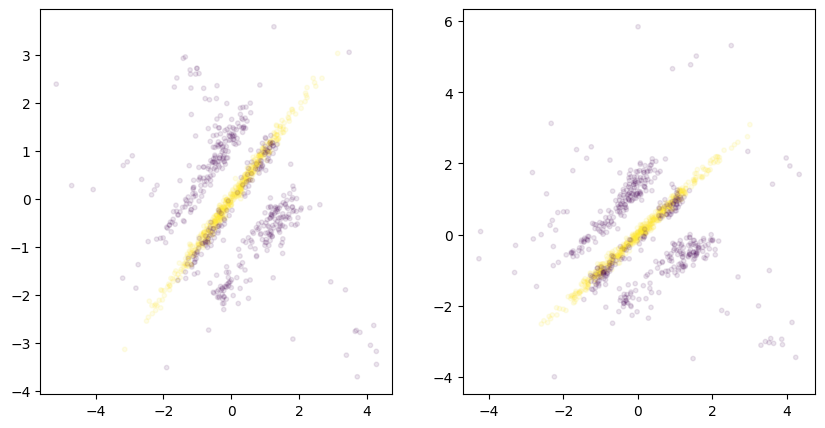

In [39]:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        # plot latitude
        #axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
        axs[0].scatter(X_train[:, 0].cpu().detach().numpy(), X_train[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_train.cpu().numpy())
        axs[1].scatter(X_test[:, 0].cpu().detach().numpy(), X_test[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_test.cpu().numpy())

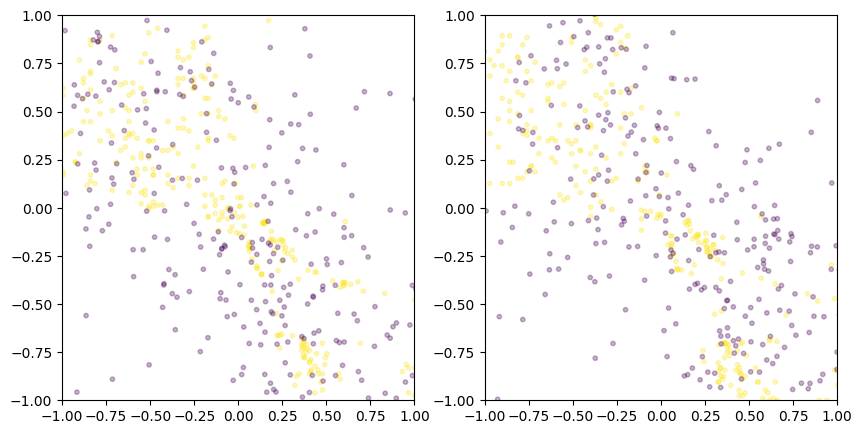

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot latitude
#axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
axs[0].scatter(X_train[:, 6].cpu().detach().numpy(), X_train[:, 7].cpu().detach().numpy(), label="True", s=10, alpha=0.3, c=y_train.cpu().numpy())
axs[1].scatter(X_test[:, 6].cpu().detach().numpy(), X_test[:, 7].cpu().detach().numpy(), label="True", s=10, alpha=0.3, c=y_test.cpu().numpy())
#axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
#axs[1].scatter(X_false[:, 0].cpu().detach().numpy(), X_false[:, 1].cpu().detach().numpy(), label="False", s=3, alpha=0.5, c=y.cpu().numpy()[:1000])
# restrict x and y axis
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(-1, 1)
axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-1, 1)
plt.show()

In [ ]:
torch.mean(torch.sum(tabpfn_output * torch.log2(tabpfn_output + 1e-6), dim=1))

In [ ]:
torch.sum(tabpfn_output * torch.log2(tabpfn_output + 1e-6), dim=1)

In [ ]:
X

In [ ]:
tabpfn_output

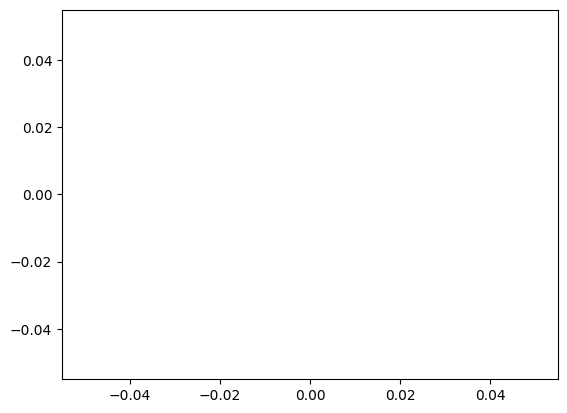

In [56]:
import matplotlib.pyplot as plt
plt.scatter(y[single_eval_pos:max_samples].cpu().numpy(), torch.sum(tabpfn_output * torch.log2(tabpfn_output + 1e-6), dim=1).cpu().detach().numpy())

In [ ]:
tabpfn_output.mean(dim=0)

In [ ]:
tabpfn_output.mean(dim=0)

In [ ]:
plt.plot(loss_list)

In [ ]:
#density
#plt.hist(X_false[:, 1].cpu().detach().numpy(), bins=100, alpha=0.5, label="False", density=True)
#plt.hist(X_true[:, 1].cpu().detach().numpy(), bins=100, alpha=0.5, label="True", density=True)

In [ ]:
np.unique(y.cpu().numpy()[:single_eval_pos], return_counts=True)

In [ ]:
np.unique(y_pred_rf, return_counts=True)

In [46]:
np.unique(y_pred_rf.detach().cpu().flatten(), return_counts=True)

(array([0, 1]), array([479, 521]))

In [13]:
mask

True

Accuracy RF: 0.816


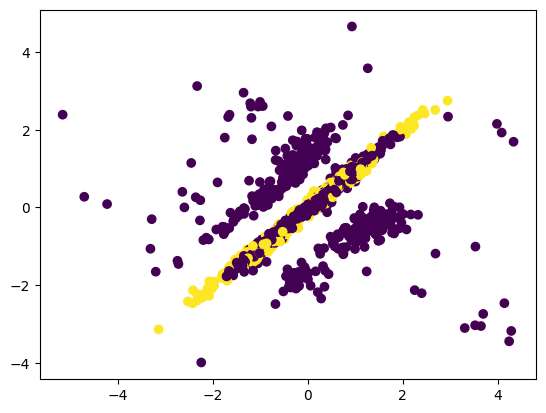

torch.Size([11000, 100]) torch.Size([100, 100])


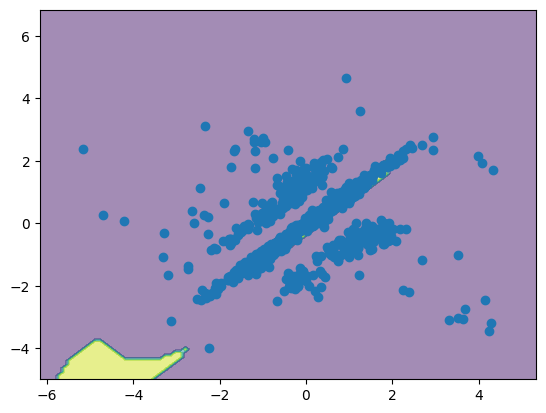

In [47]:
rf = RandomForestClassifier()
#rf.fit(X.cpu().detach().numpy()[:single_eval_pos, :2], y.cpu().numpy()[:single_eval_pos])
y_pred = tabpfn((X, y), single_eval_pos=single_eval_pos)
# convert to predictions
y_pred_rf = y_pred.argmax(dim=1)
#y_pred_rf = rf.predict(X.cpu().detach().numpy()[single_eval_pos:max_samples, :2])
#y_pred_proba_rf = rf.predict_proba(X.cpu().detach().numpy()[single_eval_pos:max_samples, :2])
accuracy_rf = accuracy_score(y.cpu().numpy()[single_eval_pos:max_samples], y_pred_rf.cpu().numpy())
print(f"Accuracy RF: {accuracy_rf}")

# plot rf predictions for 10 samples
import matplotlib.pyplot as plt
#plt.scatter(X.cpu().detach().numpy()[single_eval_pos:max_samples, 0], X.cpu().detach().numpy()[single_eval_pos:max_samples, 1], c=y_pred_rf)
#plt.scatter(y.cpu().numpy()[single_eval_pos:max_samples], y_pred_proba_rf[:, 0])
# show samples where the rf is wrong
mask = y.cpu().numpy()[single_eval_pos:max_samples] != y_pred_rf.cpu().numpy()
# plot everything and color with the mask
plt.scatter(X.cpu().detach().numpy()[single_eval_pos:max_samples, 0], X.cpu().detach().numpy()[single_eval_pos:max_samples, 1], c=mask, cmap='viridis')
#plt.scatter(X.cpu().detach().numpy()[single_eval_pos:max_samples, 0][mask], X.cpu().detach().numpy()[single_eval_pos:max_samples, 1][mask], c=y_pred_rf[mask], alpha=0.3)
#cmap='viridis')
plt.show()

# show decision boundary of the random forest
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# create a meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
X_grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1).to(device)
# concatenate X_train and X_grid
#X_grid = torch.cat((X_grid, torch.zeros((X_grid.shape[0], 100 - X_grid.shape[1])).to(device)), dim=1)
# concatenate X_train and X_grid
# pad X_grid with zeros
X_grid = torch.cat((X_grid, torch.zeros((X_grid.shape[0], 100 - X_grid.shape[1])).to(device)), dim=1)
X_grid = torch.cat((X[:single_eval_pos], X_grid), dim=0)
y_grid = torch.cat((y[:single_eval_pos], torch.zeros(X_grid.shape[0] - single_eval_pos).to(device)), dim=0)
print(X_grid.shape, yy.shape)
#Z = rf.predict(X_grid.cpu().numpy()).reshape(xx.shape)
Z = tabpfn((X_grid, y_grid), single_eval_pos=len(X_train)).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, alpha=0.5)
plt.scatter(X.cpu().detach().numpy()[single_eval_pos:max_samples, 0], X.cpu().detach().numpy()[single_eval_pos:max_samples, 1]) #c=y.cpu().numpy()[single_eval_pos:max_samples])
plt.show()

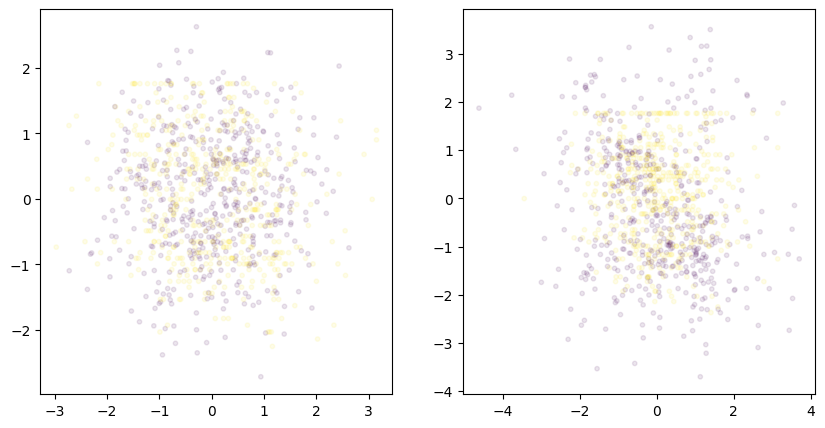

In [40]:
# plot latitude (6) and longitude for X_true and X_false
import matplotlib.pyplot as plt
# create 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot latitude
#axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
axs[0].scatter(X_train[:, 0].cpu().detach().numpy(), X_train[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_train.cpu().numpy())
axs[1].scatter(X_test[:, 0].cpu().detach().numpy(), X_test[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y_test.cpu().numpy())
#axs[0].scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), label="True", s=10, alpha=0.1, c=y.cpu().numpy())
#axs[1].scatter(X_false[:, 0].cpu().detach().numpy(), X_false[:, 1].cpu().detach().numpy(), label="False", s=3, alpha=0.5, c=y.cpu().numpy()[:1000])
plt.show()

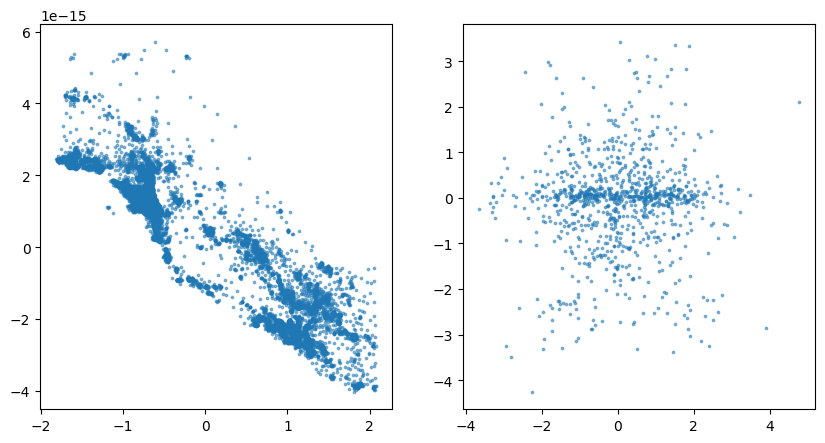

In [43]:
# plot latitude (6) and longitude for X_true and X_false
import matplotlib.pyplot as plt
# create 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
# plot latitude
axs[0].scatter(X_true[:, 6].cpu().detach().numpy(), X_true[:, 7].cpu().detach().numpy(), label="True", s=3, alpha=0.5)
axs[1].scatter(X_false[:, 6].cpu().detach().numpy(), X_false[:, 7].cpu().detach().numpy(), label="False", s=3, alpha=0.5)
plt.show()

In [ ]:
plt.plot(loss_list)

In [ ]:
(X_false.grad == 0).float().mean()

In [13]:
tabpfn_input.shape

torch.Size([1000, 2])

In [15]:
from tabpfn import TabPFNClassifier
#tabpfn_input = torch.tensor(X).to("cuda:0").float()
#target = torch.tensor(y).to("cuda:0")
single_eval_pos = 1000
max_samples = 1500
tabpfn = TabPFNClassifier(device="cuda:0").model[2]
# no requires_grad for the tabpfn
for param in tabpfn.parameters():
    param.requires_grad = False
tabpfn_input = X.reshape(X.shape[0], 1, X.shape[1])
#tabpfn_input = X[:1000]
#y = y[:1000]
#print(tabpfn_input.shape)
tabpfn_input = preprocess_input(tabpfn_input, y, single_eval_pos, preprocess_transform="none", device="cuda:0")
#print(tabpfn_input.shape)
#tabpfn_outputs = tabpfn((tabpfn_input, y), single_eval_pos=single_eval_pos)
tabpfn_outputs = tabpfn((X[:max_samples], y[:max_samples]), single_eval_pos=single_eval_pos)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1500x2 and 100x512)

In [2]:
# compute accuracy
from sklearn.metrics import accuracy_score
y_pred = tabpfn_outputs.argmax(dim=1)
accuracy = accuracy_score(y[single_eval_pos:max_samples].cpu().numpy(), y_pred.cpu().numpy())
print(f"Accuracy: {accuracy}")

NameError: name 'tabpfn_outputs' is not defined

In [49]:
import random
import time
from torch.utils.checkpoint import checkpoint
def transformer_predict(model, eval_xs, eval_ys, eval_position,
                        device='cpu',
                        max_features=100,
                        style=None,
                        inference_mode=False,
                        num_classes=2,
                        extend_features=True,
                        normalize_with_test=False,
                        normalize_to_ranking=False,
                        softmax_temperature=0.0,
                        multiclass_decoder='permutation',
                        preprocess_transform='mix',
                        categorical_feats=[],
                        feature_shift_decoder=False,
                        N_ensemble_configurations=10,
                        batch_size_inference=16,
                        differentiable_hps_as_style=False,
                        average_logits=True,
                        fp16_inference=False,
                        normalize_with_sqrt=False,
                        seed=0,
                        no_grad=True,
                        return_logits=False,
                        **kwargs):
    """

    :param model:
    :param eval_xs:
    :param eval_ys:
    :param eval_position:
    :param rescale_features:
    :param device:
    :param max_features:
    :param style:
    :param inference_mode:
    :param num_classes:
    :param extend_features:
    :param normalize_to_ranking:
    :param softmax_temperature:
    :param multiclass_decoder:
    :param preprocess_transform:
    :param categorical_feats:
    :param feature_shift_decoder:
    :param N_ensemble_configurations:
    :param average_logits:
    :param normalize_with_sqrt:
    :param metric_used:
    :return:
    """
    num_classes = len(torch.unique(eval_ys))

    def predict(eval_xs, eval_ys, used_style, softmax_temperature, return_logits):
        # Initialize results array size S, B, Classes

        # no_grad disables inference_mode, because otherwise the gradients are lost
        inference_mode_call = torch.inference_mode() if inference_mode and no_grad else NOP()
        with inference_mode_call:
            start = time.time()
            output = model(
                    (used_style.repeat(eval_xs.shape[1], 1) if used_style is not None else None, eval_xs, eval_ys.float()),
                    single_eval_pos=eval_position)[:, :, 0:num_classes]

            output = output[:, :, 0:num_classes] / torch.exp(softmax_temperature)
            if not return_logits:
                output = torch.nn.functional.softmax(output, dim=-1)
            #else:
            #    output[:, :, 1] = model((style.repeat(eval_xs.shape[1], 1) if style is not None else None, eval_xs, eval_ys.float()),
            #               single_eval_pos=eval_position)

            #    output[:, :, 1] = torch.sigmoid(output[:, :, 1]).squeeze(-1)
            #    output[:, :, 0] = 1 - output[:, :, 1]

        #print('RESULTS', eval_ys.shape, torch.unique(eval_ys, return_counts=True), output.mean(axis=0))

        return output

    def preprocess_input(eval_xs, preprocess_transform):
        import warnings

        if eval_xs.shape[1] > 1:
            raise Exception("Transforms only allow one batch dim - TODO")
        if preprocess_transform != 'none':
            if preprocess_transform == 'power' or preprocess_transform == 'power_all':
                pt = PowerTransformer(standardize=True)
            elif preprocess_transform == 'quantile' or preprocess_transform == 'quantile_all':
                pt = QuantileTransformer(output_distribution='normal')
            elif preprocess_transform == 'robust' or preprocess_transform == 'robust_all':
                pt = RobustScaler(unit_variance=True)

        # eval_xs, eval_ys = normalize_data(eval_xs), normalize_data(eval_ys)
        eval_xs = normalize_data(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position)

        # Removing empty features
        eval_xs = eval_xs[:, 0, :]
        sel = [len(torch.unique(eval_xs[0:eval_ys.shape[0], col])) > 1 for col in range(eval_xs.shape[1])]
        eval_xs = eval_xs[:, sel]

        warnings.simplefilter('error')
        if preprocess_transform != 'none':
            eval_xs = eval_xs.cpu().numpy()
            feats = set(range(eval_xs.shape[1])) if 'all' in preprocess_transform else set(
                range(eval_xs.shape[1])) - set(categorical_feats)
            for col in feats:
                try:
                    pt.fit(eval_xs[0:eval_position, col:col + 1])
                    trans = pt.transform(eval_xs[:, col:col + 1])
                    # print(scipy.stats.spearmanr(trans[~np.isnan(eval_xs[:, col:col+1])], eval_xs[:, col:col+1][~np.isnan(eval_xs[:, col:col+1])]))
                    eval_xs[:, col:col + 1] = trans
                except:
                    pass
            eval_xs = torch.tensor(eval_xs).float()
        warnings.simplefilter('default')

        eval_xs = eval_xs.unsqueeze(1)

        # TODO: Caution there is information leakage when to_ranking is used, we should not use it
        eval_xs = remove_outliers(eval_xs, normalize_positions=-1 if normalize_with_test else eval_position) \
                if not normalize_to_ranking else normalize_data(to_ranking_low_mem(eval_xs))
        # Rescale X
        eval_xs = normalize_by_used_features_f(eval_xs, eval_xs.shape[-1], max_features,
                                               normalize_with_sqrt=normalize_with_sqrt)

        return eval_xs.to(device)

    eval_xs, eval_ys = eval_xs.to(device), eval_ys.to(device)
    eval_ys = eval_ys[:eval_position]

    model.to(device)

    model.eval()

    import itertools
    if not differentiable_hps_as_style:
        style = None

    if style is not None:
        style = style.to(device)
        style = style.unsqueeze(0) if len(style.shape) == 1 else style
        num_styles = style.shape[0]
        softmax_temperature = softmax_temperature if softmax_temperature.shape else softmax_temperature.unsqueeze(
            0).repeat(num_styles)
    else:
        num_styles = 1
        style = None
        softmax_temperature = torch.log(torch.tensor([0.8]))

    styles_configurations = range(0, num_styles)
    def get_preprocess(i):
        if i == 0:
            return 'power_all'
#            if i == 1:
#                return 'robust_all'
        if i == 1:
            return 'none'

    preprocess_transform_configurations = ['none', 'power_all'] if preprocess_transform == 'mix' else [preprocess_transform]

    if seed is not None:
        torch.manual_seed(seed)

    feature_shift_configurations = torch.randperm(eval_xs.shape[2]) if feature_shift_decoder else [0]
    class_shift_configurations = torch.randperm(len(torch.unique(eval_ys))) if multiclass_decoder == 'permutation' else [0]

    ensemble_configurations = list(itertools.product(class_shift_configurations, feature_shift_configurations))
    #default_ensemble_config = ensemble_configurations[0]

    rng = random.Random(seed)
    rng.shuffle(ensemble_configurations)
    ensemble_configurations = list(itertools.product(ensemble_configurations, preprocess_transform_configurations, styles_configurations))
    ensemble_configurations = ensemble_configurations[0:N_ensemble_configurations]
    #if N_ensemble_configurations == 1:
    #    ensemble_configurations = [default_ensemble_config]

    output = None

    eval_xs_transformed = {}
    inputs, labels = [], []
    start = time.time()
    for ensemble_configuration in ensemble_configurations:
        (class_shift_configuration, feature_shift_configuration), preprocess_transform_configuration, styles_configuration = ensemble_configuration

        style_ = style[styles_configuration:styles_configuration+1, :] if style is not None else style
        softmax_temperature_ = softmax_temperature[styles_configuration]

        eval_xs_, eval_ys_ = eval_xs.clone(), eval_ys.clone()

        if preprocess_transform_configuration in eval_xs_transformed:
            eval_xs_ = eval_xs_transformed[preprocess_transform_configuration].clone()
        else:
            eval_xs_ = preprocess_input(eval_xs_, preprocess_transform=preprocess_transform_configuration)
            if no_grad:
                eval_xs_ = eval_xs_.detach()
            eval_xs_transformed[preprocess_transform_configuration] = eval_xs_

        eval_ys_ = ((eval_ys_ + class_shift_configuration) % num_classes).float()

        eval_xs_ = torch.cat([eval_xs_[..., feature_shift_configuration:],eval_xs_[..., :feature_shift_configuration]],dim=-1)

        # Extend X
        if extend_features:
            eval_xs_ = torch.cat(
                [eval_xs_,
                 torch.zeros((eval_xs_.shape[0], eval_xs_.shape[1], max_features - eval_xs_.shape[2])).to(device)], -1)
        inputs += [eval_xs_]
        labels += [eval_ys_]

    inputs = torch.cat(inputs, 1)
    inputs = torch.split(inputs, batch_size_inference, dim=1)
    labels = torch.cat(labels, 1)
    labels = torch.split(labels, batch_size_inference, dim=1)
    #print('PREPROCESSING TIME', str(time.time() - start))
    outputs = []
    start = time.time()
    for batch_input, batch_label in zip(inputs, labels):
        #preprocess_transform_ = preprocess_transform if styles_configuration % 2 == 0 else 'none'
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",
                                    message="None of the inputs have requires_grad=True. Gradients will be None")
            warnings.filterwarnings("ignore",
                                    message="torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
            if device == 'cpu':
                output_batch = checkpoint(predict, batch_input, batch_label, style_, softmax_temperature_, True)
            else:
                with torch.cuda.amp.autocast(enabled=fp16_inference):
                    output_batch = checkpoint(predict, batch_input, batch_label, style_, softmax_temperature_, True)
        outputs += [output_batch]
    #print('MODEL INFERENCE TIME ('+str(batch_input.device)+' vs '+device+', '+str(fp16_inference)+')', str(time.time()-start))

    outputs = torch.cat(outputs, 1)
    for i, ensemble_configuration in enumerate(ensemble_configurations):
        (class_shift_configuration, feature_shift_configuration), preprocess_transform_configuration, styles_configuration = ensemble_configuration
        output_ = outputs[:, i:i+1, :]
        output_ = torch.cat([output_[..., class_shift_configuration:],output_[..., :class_shift_configuration]],dim=-1)

        #output_ = predict(eval_xs, eval_ys, style_, preprocess_transform_)
        if not average_logits and not return_logits:
            # transforms every ensemble_configuration into a probability -> equal contribution of every configuration
            output_ = torch.nn.functional.softmax(output_, dim=-1)
        output = output_ if output is None else output + output_

    output = output / len(ensemble_configurations)
    if average_logits and not return_logits:
        output = torch.nn.functional.softmax(output, dim=-1)

    output = torch.transpose(output, 0, 1)

    return output

In [ ]:
tabpfn_input = X.reshape(X.shape[0], 1, X.shape[1])[:max_samples]
tabpfn_output = transformer_predict(tabpfn, tabpfn_input, y[:max_samples].reshape(-1, 1), eval_position=single_eval_pos, device="cuda:0", no_grad=False, preprocess_transform="none")
tabpfn_output = tabpfn_output.squeeze(0)

In [ ]:
# compute accuracy
y_pred = tabpfn_output.argmax(dim=1)
accuracy = accuracy_score(y[single_eval_pos:max_samples].cpu().numpy(), y_pred.cpu().numpy())
print(f"Accuracy: {accuracy}")

In [ ]:
tabpfn_output.shape

In [ ]:
tabpfn_input.shape

In [ ]:
tabpfn_input.shape